In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
up = np.array([0, 1])
down = np.array([0, -1])
left = np.array([-1, 0])
right = np.array([1, 0])
directions = [up, down, left, right]


def init(L,n):
    boards = np.zeros((n,L,L))
    cur_loc = npr.randint(L, size = (n,2))
    for i in np.arange(n):
        j, k = cur_loc[i]
        boards[i, j, k] = 1
    return boards, cur_loc


def move(boards, cur_loc, pin, Wn, n, L, respl=False):
    avail_dir = np.zeros((n,4))
    for ind_dir in range(4):
        _dir = directions[ind_dir]
        img = cur_loc + _dir
        for n0 in range(n):
            x, y = img[n0]
            x %= L
            y %= L
            if boards[n0,x,y] == 0:
                avail_dir[n0, ind_dir] = 1 

    mn = np.sum(avail_dir, axis=1)
    _z_rat = mn * pin / sum(pin)
    # _z_rat = mn * Wn
    z_rat = np.sum(_z_rat)
    
    wn = mn / z_rat
    
    pin = np.divide(pin, mn, out=np.zeros_like(pin), where=(mn!=0))
    
    numer = Wn * wn
    Wn = numer / np.sum(Wn)
    
    for n0 in range(n):
        if mn[n0] == 0:
            continue
        avails = avail_dir[n0]
        prob = avails / mn[n0]
        random_move = npr.choice([0,1,2,3], p=prob)
        x,y = cur_loc[n0] + directions[random_move]
        x %= L
        y %= L
        cur_loc[n0] = [x,y]
        boards[n0,x,y] = 1
        
    if respl:
        boards, Wn, cur_loc, mn, pin, wn = resample(boards, Wn, cur_loc, mn, pin, wn)

    #print(boards, cur_loc, mn, pin)
    return boards, cur_loc, mn, pin, z_rat, wn, Wn

def get_Nk(methods, nomg): # methods = 1,2,3
    if methods == 1:
        Nk = npr.multinomial(N, nomg)

    elif methods == 2:
        expected = N * nomg
        decimal, integer = np.modf(expected)
        U = npr.uniform(size=N)
        Nk = integer + (U < decimal)

    elif methods == 3:
        Un = npr.uniform(size=N)
        j = np.arange(1,N+1)
        Unj = (j-Un)/N
        bounds = np.cumsum(nomg)
        bounds = np.concatenate(([-np.inf], bounds, [np.inf]))
        Nk = np.zeros(N)

        def _count_range(jj):
            return np.sum((bounds[jj-1] < Unj) & (Unj < bounds[jj]))
        count_range = np.vectorize(_count_range)

        Nk = count_range(j)
    
    Nk = Nk.astype(int)
    return Nk

def resample(boards, Wn, cur_loc, mn, pin, wn):
    Nk = get_Nk(3, Wn)
    boards = np.repeat(boards, Nk, axis=0)
    Wn = np.repeat(Wn, Nk, axis=0)
    cur_loc = np.repeat(cur_loc, Nk, axis=0)
    mn = np.repeat(mn, Nk)
    pin = np.repeat(pin, Nk)
    wn = np.repeat(wn, Nk)
    # print(boards, Wn, cur_loc, mn, pin, wn)
    return boards, Wn, cur_loc, mn, pin, wn

d = 5
n = int(1e4)
L = 5
Wn = np.ones(n)/n
boards, cur_loc = init(L, n)
starts = np.copy(cur_loc[0])
pin = np.ones(n)/L**2
Z = L ** 2
Zs = np.zeros(d)
Zs[0] = Z
for i in range(d):
    boards, cur_loc, mn, pin, z_rat, wn, Wn = move(boards, cur_loc, pin, Wn, n, L, respl=False)
    Z *= z_rat
    Zs[i] = Z
ends = cur_loc[0]
print(z_rat)
print(Z)

2.832266209756856
7091.937943903625


In [2]:
boards.shape

(10000, 5, 5)

Check the visit times

In [3]:
np.sum(boards, axis=0)

array([[2344., 2355., 2403., 2405., 2384.],
       [2397., 2369., 2428., 2437., 2428.],
       [2358., 2404., 2462., 2456., 2384.],
       [2356., 2364., 2435., 2438., 2312.],
       [2368., 2425., 2511., 2418., 2359.]])

In [4]:
wn

array([1.05922247, 0.70614831, 1.05922247, ..., 1.05922247, 0.70614831,
       0.70614831])

In [5]:
Zs

array([ 100.       ,  300.       ,  900.       , 2503.98     ,
       7091.9379439])

In [6]:
Z_respl = np.array([ 100., 300., 900., 2507.04, 7027.8973964])

In [7]:
Z_nonrespl = np.array([ 100., 300., 900., 2498.4, 7057.08])

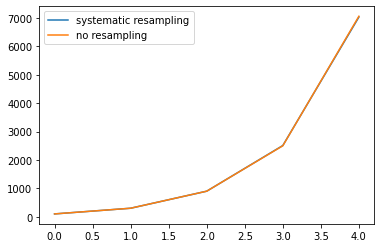

In [14]:
plt.plot(Z_respl, label='systematic resampling')
plt.plot(Z_nonrespl, label='no resampling')
plt.legend()
plt.show()

In [8]:
def plot_traj(path):
    starts = path[0]
    ends = path[-1]
    path = path.T
    x = path[0]
    y = path[1]


    plt.plot(x,y, 'bo-', linewidth = 1)
    plt.plot(*starts, 'ro', ms = 10, label='Starts')
    plt.plot(*ends, 'go', ms = 10, label='Ends')
    plt.xlim([-0.2,4.2])
    plt.ylim([-0.2,4.2])
    plt.legend()
    plt.show()
    

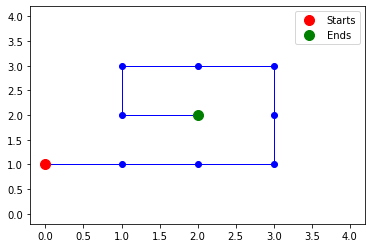

In [9]:
path = np.array([
    [0,1],[1,1],[2,1],[3,1],[3,2],[3,3],[2,3],[1,3],[1,2],[2,2]
])
plot_traj(path)

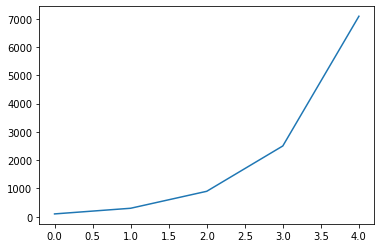

In [10]:
plt.plot(Zs)
plt.show()